# 気象台東交差点付近の交通分析

<div style="text-align: right;">
    <a href="kishodaiTraffic.ipynb">このページのオリジナルのipynbファイル</a>
</div>

csvファイルの１行目は列名

date, distance, fwd_std, fwd, rev_std,rev



In [31]:
# 8tops上で採取しているデータの閲覧
from datetime import datetime as dt, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # 時間軸のフォーマットを自在に

plt.rcParams["font.size"] = 14

class kishodai:
    '''
    読み込んだデータは地点をキーとする辞書に格納
    '''
    def __init__(self):
        self.route = {}
        self.name = {}
        self.title = {}
        # 気象台西　－　県立大入口　（飯田通）
        df = pd.read_csv(
            "/ssd/toyoki/googleData/kishodai/気象台西_県立大入口_travelTime.csv",
            sep=",",
            skipinitialspace=True)
        name =  ["気象台西", "県立大入口"]
        key = "気象台西-県立大入口"
        title = "飯田通"
                          
        df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M:%S')
        self.route[key] = {"df": df, "name": name, "title": title}
        
        # 甲府工業西　－　西中北西　（アルプス通）
        df = pd.read_csv(
            "/ssd/toyoki/googleData/kishodai/甲府工業西_西中北西_travelTime.csv",
            sep=",",
            skipinitialspace=True)
        df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M:%S')
        name = ["甲府工業西", "西中北西"]
        key = "甲府工業西-西中北西"
        title = "アルプス通"
        self.route[key] = {"df": df, "name": name, "title": title}
        
        # 中央病院入口　－　県立大入口 （北西から東）
        df = pd.read_csv(
            "/ssd/toyoki/googleData/kishodai/中央病院入口_県立大入口_travelTime.csv",
            sep=",",
            skipinitialspace=True)
        df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M:%S')
        name = ["中央病院入口", "県立大入口"]
        key = "中央病院入口-県立大入口"
        title = "富士見通―飯田通"
        self.route[key] = {"df": df, "name": name, "title": title}
        
        
    def plot_a_day(self, day):
        fig_no = 0
        fig, ax = plt.subplots(figsize=(12, 12),
                                         ncols=1,
                                         nrows=len(self.route))
        for r in self.route:
            # 描画期間の限定（全部だと多すぎる時は限定）
            day_s = dt.strptime(day, "%Y-%m-%d")
            day_e = day_s + timedelta(days=1)
            df4plot = r["df"][(day_s < r["df"]['date'])  & (r["df"]['date'] < day_e)]
            # print(df4plot['fwd'])
            df4plot.plot(
                x='date',
                y=['fwd', 'rev'],
                ax = ax[fig_no],
                label=[r["name"][0] + " ⇒ " + r["name"][1], r["name"][1]+ " ⇒ "  + r["name"][0]])
            ax[fig_no].xaxis.set_major_formatter(DateFormatter('%H:%M'))
            ax[fig_no].set_title(r["title"] + " (" + day + ")")
            fig_no += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
    def get2pointDataByTime(self, points, days, time4plot="08:00", direction='fwd'):
        '''
        同一時刻の２つのルートの所要時間を散布図に描く
        '''
        df1 = self.route[points[0]]["df"][{"date","fwd"}].copy()
        df2 = self.route[points[1]]["df"][{"date","fwd"}].copy()
        df1["date1"] = df1["date"].dt.round("1T") # 秒切り捨て
        df2["date1"] = df2["date"].dt.round("1T")
        df1["time_of_day"] = df1["date1"].dt.time # 時刻のみ
        df2["time_of_day"] = df2["date1"].dt.time
        tmp1 = df1.loc[:, {"date1","time_of_day", "fwd"}].copy()
        tmp2 = df2.loc[:, {"date1","time_of_day", "fwd"}].copy()
        df2plot = pd.merge(tmp1, tmp2, on=["date1","time_of_day"]) # ２地点データのマージ
        df2plot["day"] = df2plot["date1"].dt.round("D")
        df2plot["week"] = df2plot["date1"].dt.dayofweek
        
        #print(df2plot)
        #print(dt.strptime(time4plot, "%H:%M").time())
        return df2plot[df2plot["time_of_day"] == dt.strptime(time4plot, "%H:%M").time()]

        
    def plot_a_day_multipoints(self, day, direction='fwd'):
        '''
        １枚の図に３ルートの変化を描く
        '''
        fig = plt.figure(figsize=(12,4))
        ax = fig.add_subplot(1,1,1)
        for key in self.route:
            r = self.route[key]
            # 描画期間の限定（全部だと多すぎる時は限定）
            day_s = dt.strptime(day, "%Y-%m-%d")
            day_e = day_s + timedelta(days=1)
            df4plot = r["df"][(day_s < r["df"]['date'])  & (r["df"]['date'] < day_e)]
            if direction == 'fwd':
                origin = 0
                destination = 1
            else:
                origin = 1
                destination = 0
                
            df4plot.plot(
                x= 'date',
                y= direction,
                ax = ax,
                label=r["name"][origin] + " ⇒ " + r["name"][destination])
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
            ax.set_title(r["title"] + " (" + day + ")")
            
    def plot_a_point_days(self, point, days, direction='fwd'):
        '''
        １枚の図に一つのルートの複数日を描画
        days = 日にちのリスト
        '''
        fig = plt.figure(figsize=(12,4))
        ax = fig.add_subplot(1,1,1)
        r = self.route[point]
        df = self.route[point]["df"]
        df["time_of_day"] = df["date"].dt.time
        for d in days:
            p_day = dt.strptime(d,"%Y%m%d")
            next_day = p_day + timedelta(days=1)
            df4plot = df[(p_day < df['date']) & (df['date'] < next_day)]
            if direction == 'fwd':
                origin = 0
                destination = 1
            else:
                origin = 1
                destination = 0
                
            df4plot.plot(
                x= 'time_of_day',
                y= direction,
                ax = ax,
                label=d)
            # ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
            ax.set_title(point)
        
# 日にちのリストをつくる
def makeDaysList(sday, eday, day_of_week=None): # 曜日は月が0
    days = []
    day = sday
    while day <= eday:
        if (day_of_week == None) or int(day_of_week) == dt.strptime(day, "%Y%m%d").weekday():
            days.append(day)
        day = dt.strftime(dt.strptime(day, "%Y%m%d") + timedelta(days=1), "%Y%m%d")
    return days

## ２つのルート関する同時刻所要時間の相関

### データの取り出し

クラスkishodaiに、取り出したい時刻と日にち範囲・曜日を指定して、２地点のデータを抽出する関数 get2pointDataByTime を作成


In [32]:
# ２ルートの相関をみるためのデータ抽出
data = kishodai()
days = makeDaysList("20201001", "20201231")
data.get2pointDataByTime(["中央病院入口-県立大入口", "甲府工業西-西中北西"], days, "08:00")

time_of_day               date1  fwd_x  fwd_y        day  week
12      08:00:00 2020-09-24 08:00:00    180    212 2020-09-24     3
36      08:00:00 2020-09-25 08:00:00    287    233 2020-09-25     4
66      08:00:00 2020-09-26 08:00:00    128     85 2020-09-26     5
96      08:00:00 2020-09-27 08:00:00     98     94 2020-09-27     6
126     08:00:00 2020-09-28 08:00:00    239    210 2020-09-28     0
...          ...                 ...    ...    ...        ...   ...
2793    08:00:00 2020-12-27 08:00:00    106     95 2020-12-27     6
2823    08:00:00 2020-12-28 08:00:00    293    153 2020-12-28     0
2853    08:00:00 2020-12-29 08:00:00    167    119 2020-12-29     1
2883    08:00:00 2020-12-30 08:00:00    169    118 2020-12-30     2
2913    08:00:00 2020-12-31 08:00:00    194    116 2020-12-31     3

[98 rows x 6 columns]

### ２地点同時刻所要時間の散布図

描画関数ライブラリとしては、seabornの方が自由度がある。

Text(0, 0.5, '甲府工業西-西中北西 (sec)')

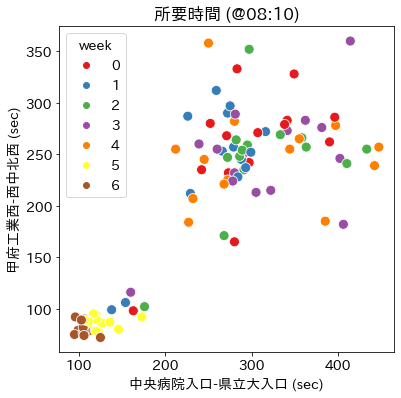

In [52]:
# 2ルートの所要時間
points = ["中央病院入口-県立大入口", "甲府工業西-西中北西"]
days = makeDaysList("20201001", "20201231")
view_time = "08:10"
data4plot = data.get2pointDataByTime(points, days, view_time)

import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=data4plot, x='fwd_x', y='fwd_y', hue='week', s=100, palette="Set1", ax=ax)

ax.set_title("所要時間 (@" + view_time +  ")")
ax.set_xlabel(points[0] + " (sec)")
ax.set_ylabel(points[1] + " (sec)")

週末と平日の差異以外は、とくに相関は見られないようだ。

## 所要時間の変動


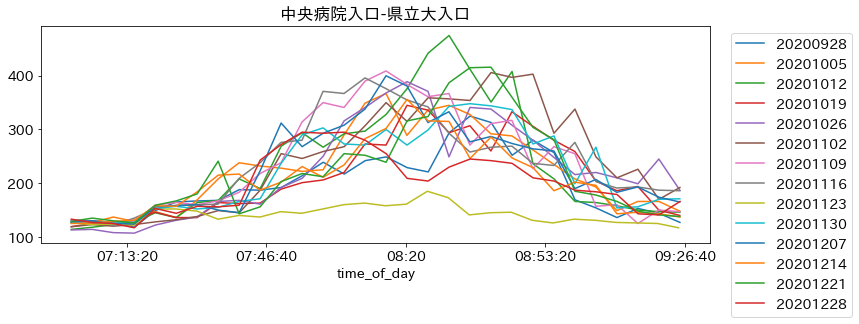

In [16]:
# 指定した日にちのデータをプロット (最初の日、最後の日、曜日でdaysのリストを作る）
data = kishodai()
# data.route["中央病院入口-県立大入口"]['df']
days = makeDaysList("20200924", "20201231", 0)
data.plot_a_point_days("中央病院入口-県立大入口", days)

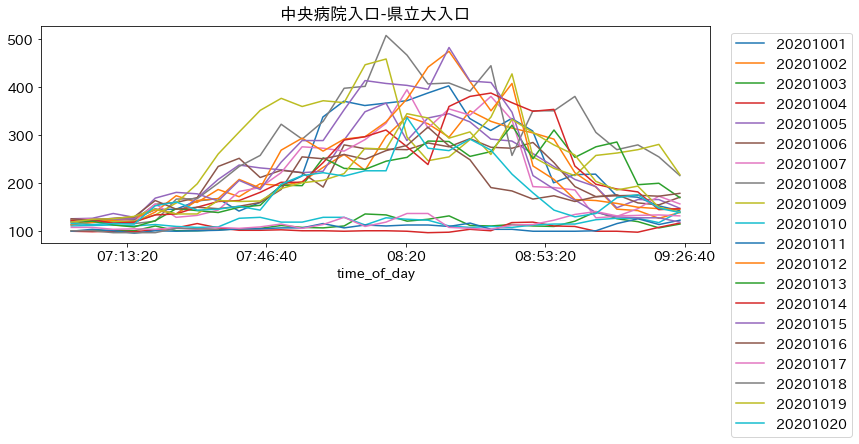

In [42]:
days = makeDaysList("20201001", "20201020")
data = kishodai()
data.plot_a_point_days("中央病院入口-県立大入口", days)

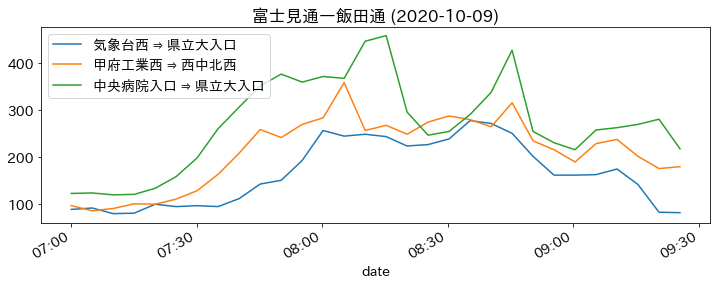

In [11]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-09")

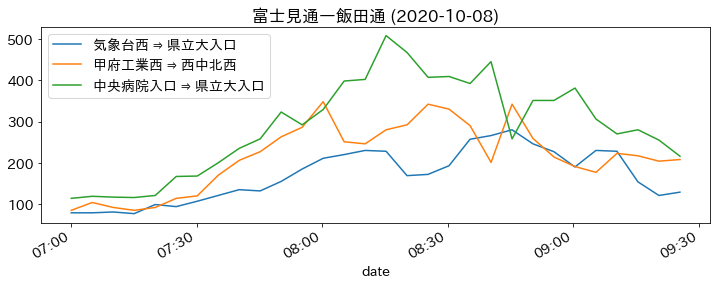

In [6]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-08")

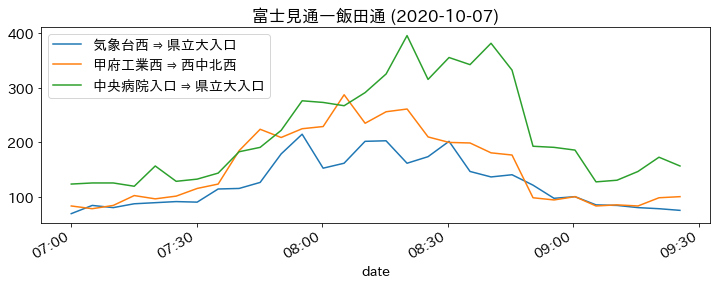

In [5]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-07")

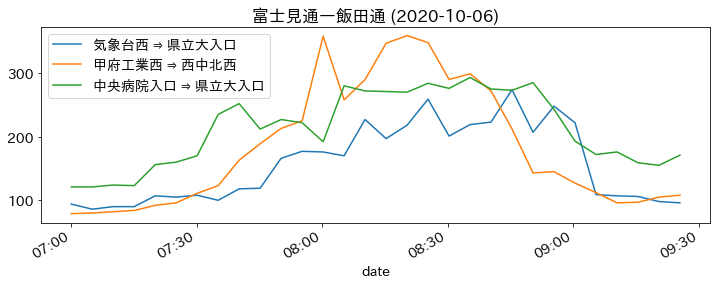

In [4]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-06")

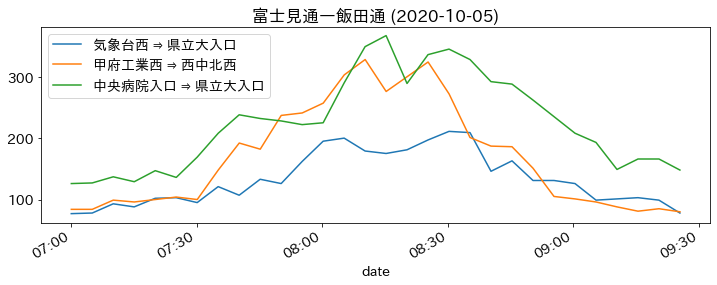

In [3]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-05")

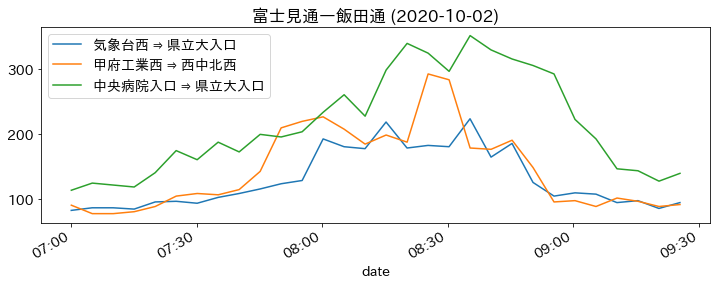

In [32]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-02")

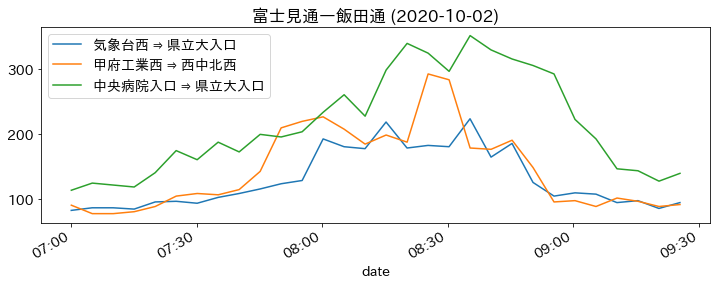

In [32]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-02")

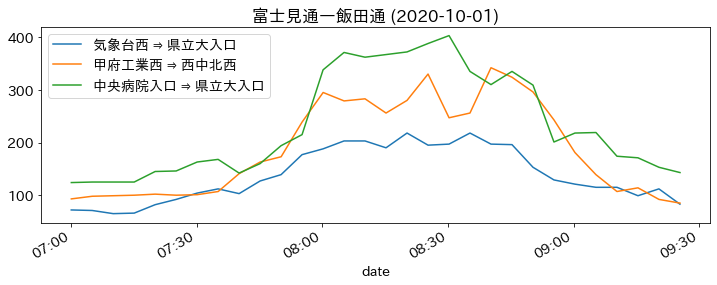

In [27]:
data = kishodai()
data.plot_a_day_multipoints("2020-10-01")

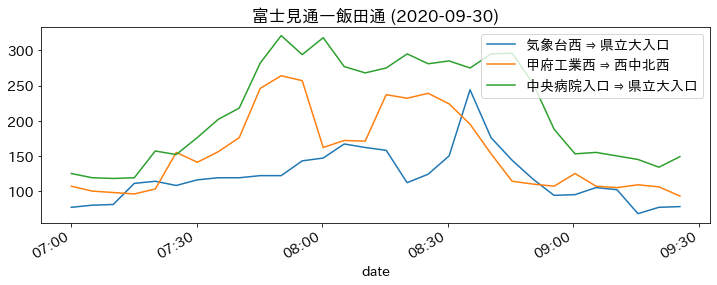

In [28]:
data.plot_a_day_multipoints("2020-09-30")

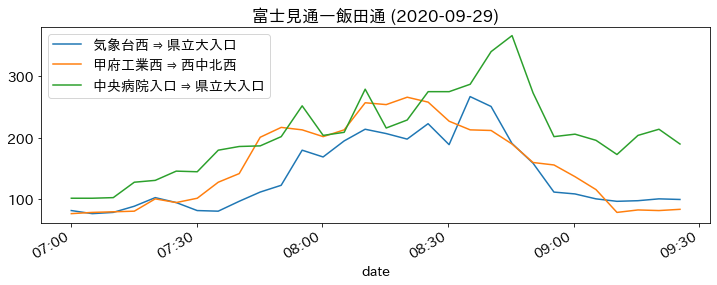

In [29]:
data.plot_a_day_multipoints("2020-09-29")

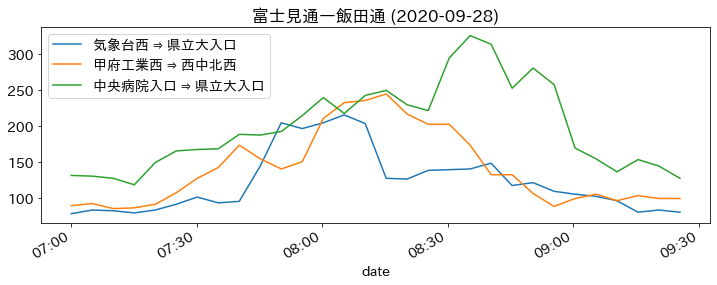

In [30]:
data.plot_a_day_multipoints("2020-09-28")

２種類のパターンがあるように見える。

以下は、道路ごとのプロット

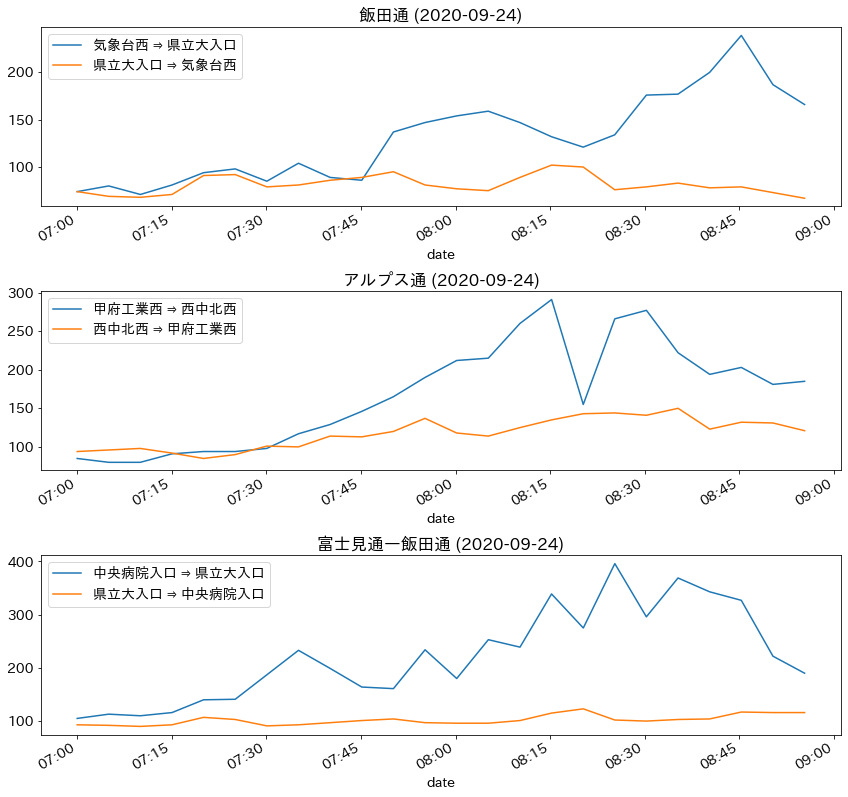

In [9]:
data = kishodai()
data.plot_a_day("2020-09-24")

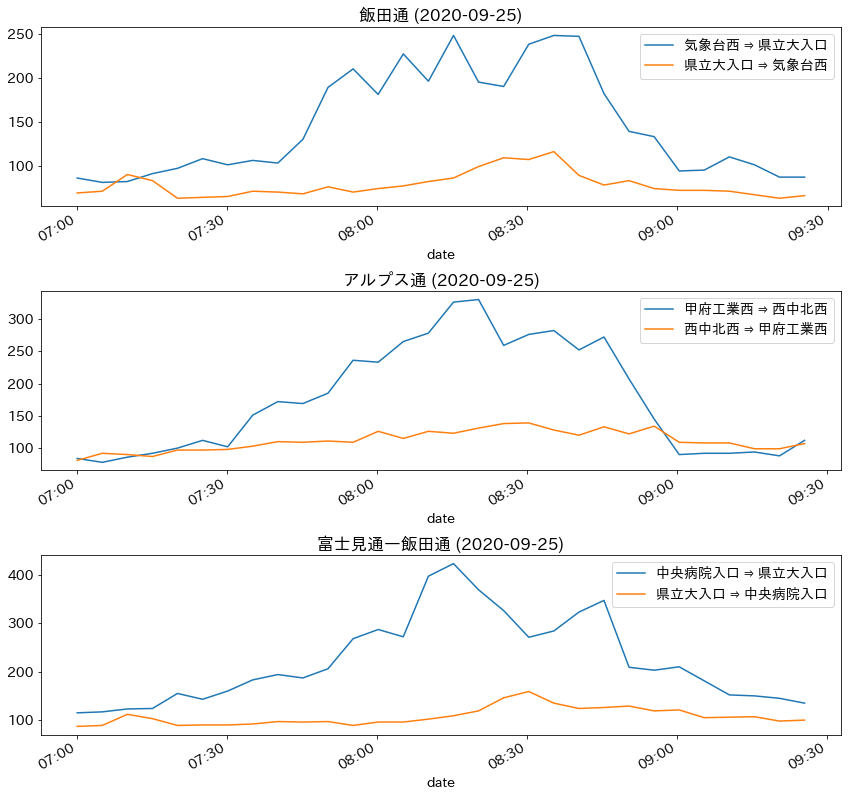

In [10]:
data = kishodai()
data.plot_a_day("2020-09-25")

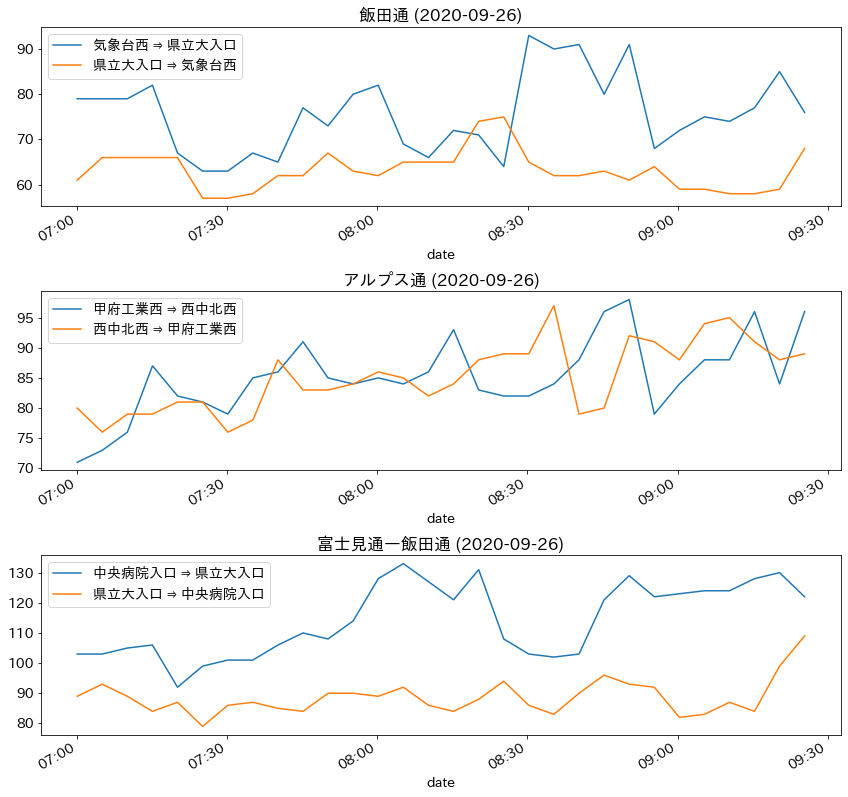

In [11]:
data = kishodai()
data.plot_a_day("2020-09-26")

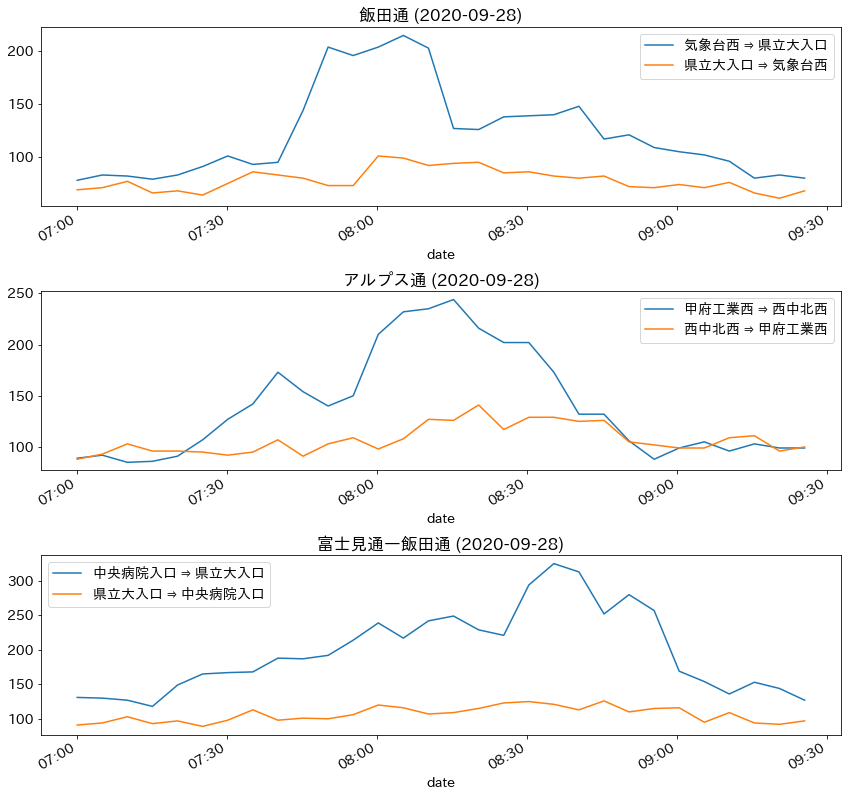

In [12]:
data = kishodai()
data.plot_a_day("2020-09-28")

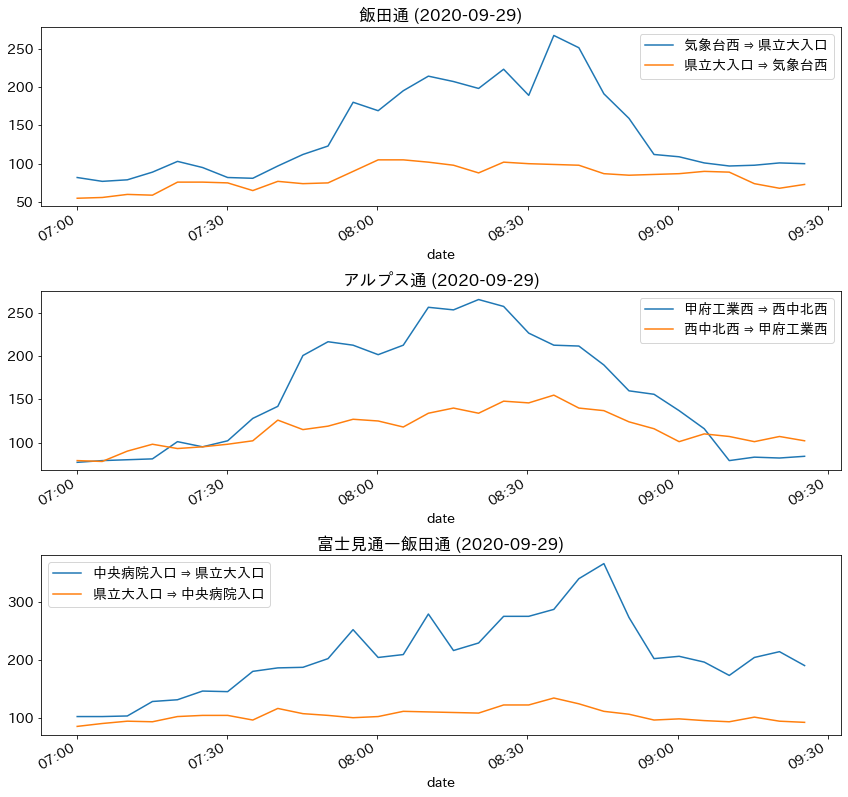

In [13]:
data = kishodai()
data.plot_a_day("2020-09-29")

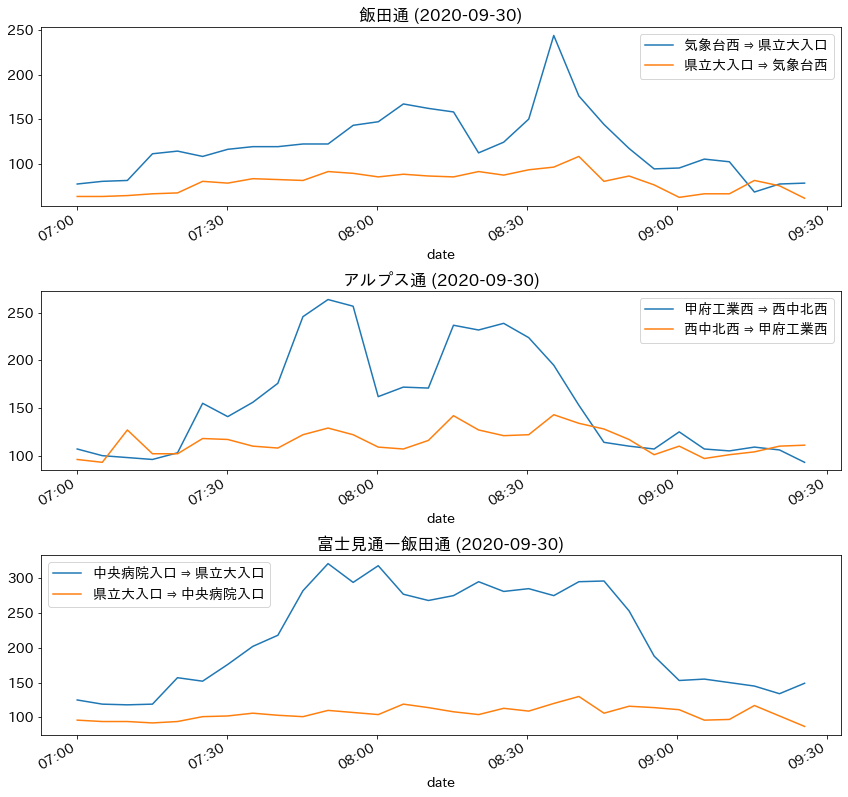

In [14]:
data = kishodai()
data.plot_a_day("2020-09-30")

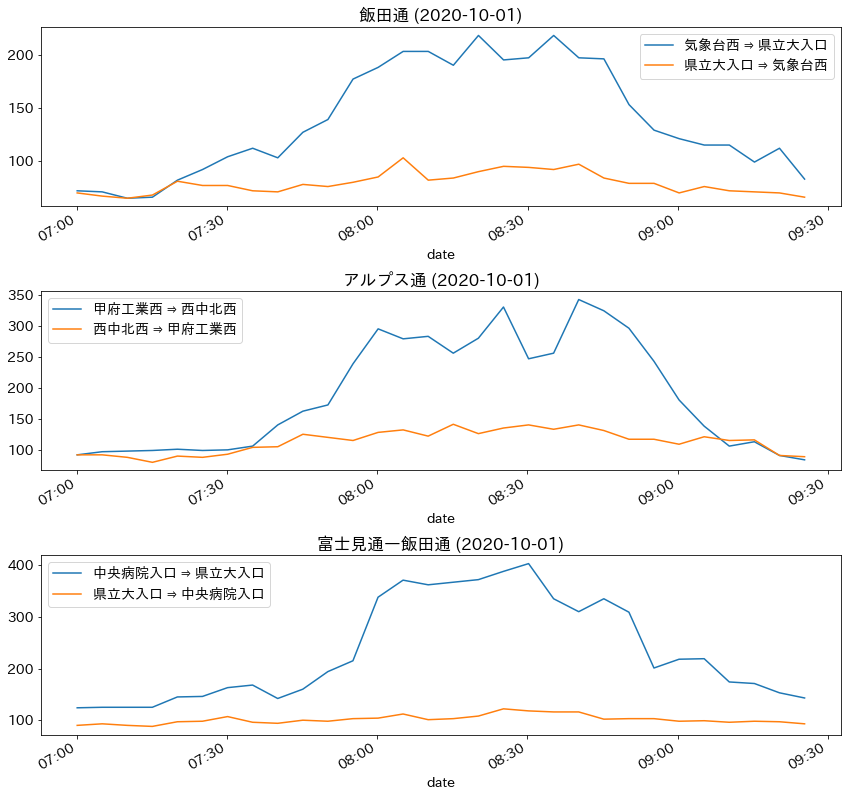

In [4]:
data = kishodai()
data.plot_a_day("2020-10-01")

飯田通の初期の混雑が全体に波及して全体の渋滞を押し上げている可能性がある。